In [2]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import geopandas as gpd

In [3]:
wd = '/Users/kevin/Dropbox/legal_censorship/'

In [4]:
df = pd.read_excel(wd+'Data/civil_docx2019_only/civil_docx2019_only_1.xlsx')
df2 = pd.read_excel(wd+'Data/civil_docx2019_only/civil_docx2019_only_2.xlsx')
df3 = pd.read_excel(wd+'Data/civil_docx2019_only/civil_docx2019_only_3.xlsx')
df = pd.concat([df, df2, df3])
del df2, df3

In [5]:
# 1,000,000
print(df.shape[0])

2889033


In [6]:
county_code = pd.read_excel(wd+'Data/shapefiles/China County Index Code.xls')
# (1) Plot the map indicating 
county_code = county_code[(~county_code.prefecture.isna()) & (county_code.dcode % 100 != 0)]
county_code['prefecture'] = county_code.apply(lambda x: x['city']+x['prefecture'] if x['prefecture'].endswith('区') else x['prefecture'], axis=1)
cty_lst = county_code.prefecture.unique()
def find_cty(court):
    for cty in cty_lst:
        if court.find(cty) != -1:
            return cty
    return np.nan

df['county'] = df.法院名称.apply(find_cty)

In [7]:
# 22% missing data, and those are mostly higher-order courts (e.g.云南省昆明市中级人民法院)
print(df.county.isna().mean())

0.22041838912881923


In [8]:
china = gpd.read_file(wd+"Data/shapefiles/chn_admbnda_adm2_ocha_2020.shp", encoding='utf-8')
def shorten_names(x):
    x = x.replace('市', '').replace('自治州', '').replace('盟', '').replace('自治县', '').replace('地区', '')
    temp = re.match(r'(.*)\[(.*)\]', x)
    temp2 = re.match(r'(.*)\〔(.*)\〕', x)
    if temp:
        return temp.group(1)
    elif temp2:
        return temp2.group(1)
    else:
        return x

china['ADM2_ZH'] = china['ADM2_ZH'].apply(shorten_names)
cty_lst = china['ADM2_ZH'].unique()
def find_cty(court):
    for cty in cty_lst:
        if court.find(cty) != -1:
            return cty
    return np.nan

df['pref'] = df.法院名称.apply(find_cty)

china['ADM2_PCODE'] = china['ADM2_PCODE'].apply(lambda x: int(x[2:]))
county_to_code = dict(county_code[['prefecture', 'dcode']].values)
pref_to_code = dict(china[['ADM2_ZH', 'ADM2_PCODE']].values)

In [9]:
pref_to_code[np.nan] = np.nan
df['code'] = df.apply(lambda x: county_to_code[x['county']] if str(x['county'])!='nan' else pref_to_code[x['pref']], axis=1)

In [10]:
# Only 1 % is now missing, which is of reasonable data quality at this moment.
df.code.isna().mean()

0.014724996218457872

In [11]:
df['code'] = df.code.apply(lambda x: x if x > 1e6 or str(x)=='nan' else 10*x)
df[['法院名称', 'code']].drop_duplicates().to_csv(wd+'Data/court_to_code.csv', index=False, encoding='utf-8')

In [12]:
df['prefcode'] = df['code'].apply(lambda x: x // 100 if str(x)!='nan' else x)
df_toplot = df.groupby('prefcode').docid.count().reset_index()
df_toplot['prefcode'] = df_toplot['prefcode'].apply(lambda x: int(x)*10)
df_toplot['docid'] = df_toplot['docid'].apply(np.log)
df['code'] = df['code'] // 10

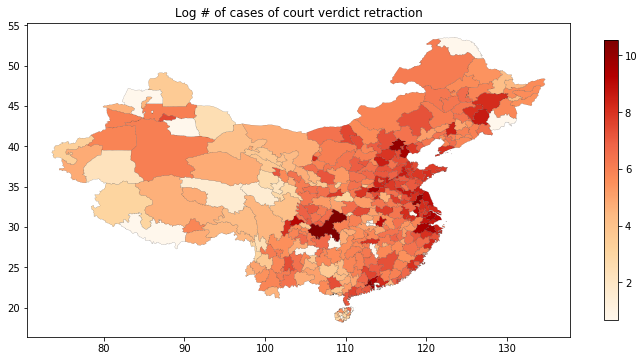

In [13]:
# # Only 4.8 % missing values now
china['GB'] = china.ADM1_PCODE.apply(lambda x: int(x[-2:]) * 1e4)
china = china[china.GB != 710000]
china = pd.merge(china.rename({'ADM2_PCODE': 'prefcode'}, axis=1), df_toplot.rename({'docid': 'no_part'}, axis=1), on='prefcode', how='left', validate='1:m')
# A 2-step process cleaning the code updates throughout the years
df_codeupdate = pd.DataFrame()
for pref in china[china.no_part.isna()].ADM2_ZH.unique():
    try:
        df_codeupdate = df_codeupdate.append({'Name': pref, 'prev_code': china[china.ADM2_ZH == pref].prefcode.iloc[0], 'new_code': df[df.pref == pref].prefcode.iloc[0]}, ignore_index=True)
    except:
        print(pref)
old_to_new_code = dict(df_codeupdate[['prev_code', 'new_code']].values)
china['prefcode'] = china['prefcode'].apply(lambda x: old_to_new_code[x] if x in old_to_new_code else x)
del china['no_part']
china.drop_duplicates(subset=['prefcode'], inplace=True)
china = pd.merge(china, df_toplot.rename({'docid': 'no_part'}, axis=1), on='prefcode', how='left', validate='1:m')

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Log # of cases of court verdict retraction')
gpd.GeoDataFrame(china).plot(column='no_part', cmap='OrRd', edgecolor='black', lw=0.1, ax=ax, legend=True, legend_kwds={'shrink': 0.4})
plt.tight_layout()
plt.savefig(wd+'Figure/count_retract_log.png', dpi=300)

In [48]:
df_otherattr = pd.read_excel(wd+'Data/civil_docx2019_only_cleaning/extracted_civil_docx2019_only_1.xlsx')
df_temp2 = pd.read_excel(wd+'Data/civil_docx2019_only_cleaning/extracted_civil_docx2019_only_2.xlsx')
df_temp3 = pd.read_excel(wd+'Data/civil_docx2019_only_cleaning/extracted_civil_docx2019_only_3.xlsx')
df_otherattr = pd.concat([df_otherattr, df_temp2, df_temp3])

In [58]:
df = pd.merge(df, df_otherattr[[x for x in df_otherattr.columns if x == 'docid' or x not in df.columns]], on='docid', how='left', validate='1:1')

In [92]:
df['发布月'] = df['发布日期'].apply(lambda x: x[:7])
data = df.groupby(['发布月']).size().reset_index(name='count')
data = data[data.发布月.apply(lambda x: x[:4] > '2012' and x[:4] < '2020')]
plt.figure()
plt.title('# of retracted cases, by time of verdict publication')
plt.bar(data['发布月'], data['count'], color='maroon')
plt.xticks(['2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01', '2020-01'], ['2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.savefig(wd+'Figure/count_retract_trend_publication.png', dpi=300)

In [105]:
df['court_date'] = df.apply(lambda x: x['起诉'] if str(x['起诉'])!='nan' else np.nan, axis=1)
df['court_date'] = df.apply(lambda x: x['申请'] if str(x['申请'])!='nan' else x['court_date'], axis=1)
df['court_date'] = df.apply(lambda x: x['立案'] if str(x['立案'])!='nan' else x['court_date'], axis=1)
df['court_date'] = df.apply(lambda x: x['受理'] if str(x['受理'])!='nan' else x['court_date'], axis=1)
df['court_date'] = df.apply(lambda x: x['撤诉'] if str(x['撤诉'])!='nan' else x['court_date'], axis=1)
df['court_date'] = df.apply(lambda x: x['开庭'] if str(x['开庭'])!='nan' else x['court_date'], axis=1)

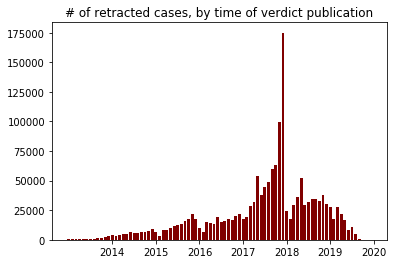

In [107]:
df['发布月'] = df['court_date'].apply(lambda x: x[:7] if isinstance(x, str) else np.nan)
data = df.groupby(['发布月']).size().reset_index(name='count')
data = data[~data.发布月.isna()]
data = data[data.发布月.apply(lambda x: x[:4] > '2012' and x[:4] < '2020')]
plt.figure()
plt.title('# of retracted cases, by time of verdict publication')
plt.bar(data['发布月'], data['count'], color='maroon')
plt.xticks(['2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01', '2020-01'], ['2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.savefig(wd+'Figure/count_retract_trend_courtdate.png', dpi=300)
del df['发布月']

In [112]:
# Question # 1 -- among the "censored" docs, whether local firms gets preferred.
df['plantifflose'] = df['原告pay'] >= df['被告pay']

In [113]:
df.columns

Index(['文书ID', '案件名称', '全文', '案号', '审判程序', '裁判日期', '发布日期', '法院名称', '案件类型',
       '公开类型', '文书类型', '案由', 'docid', 'fname', 'county', 'pref', 'code',
       'prefcode', '原告loc', '被告loc', 'type_原被告', '上诉', '原告pay', '被告pay',
       '类型_pay', '案件受理费', '受理费合计', '受理费减半', '受理费免收', '起诉', '申请', '立案', '受理',
       '撤诉', '开庭', 'court_date', 'plantifflose'],
      dtype='object')

In [114]:
df['winner'] = df.apply(lambda x: x['被告loc'] if x['plantifflose'] else x['原告loc'], axis=1)
df['loser'] = df.apply(lambda x: x['原告loc'] if x['plantifflose'] else x['被告loc'], axis=1)
df['winner'] = df['winner'].apply(literal_eval)
df['loser'] = df['loser'].apply(literal_eval)

In [134]:
df['local_winner'] = df.apply(lambda x: str(int(x['code'])) in x['winner'][0] if str(x['code'])!='nan' and len(x['winner']) > 0 else np.nan, axis=1)
df['local_loser'] = df.apply(lambda x: str(int(x['code'])) in x['loser'][0] if str(x['code'])!='nan' and len(x['loser']) > 0 else np.nan, axis=1)

In [135]:
# 4 scenarios, 
# (1) local winner, local loser
# (2) local winner, non-local loser
# (3) non-local winner, local loser
# (4) non-local winner, non-local loser
# We want to compute (1) + (3) / all
df.to_csv(wd+'Data/master.csv', index=False)

In [138]:
print(df[(~df.local_winner.isna()) & (~df.local_loser.isna())].local_loser.mean())
print(df[(~df.local_winner.isna()) & (~df.local_loser.isna())].local_winner.mean())

# Focusing on local vs. non-local cases,
# df[['local_winner', 'local_loser', 'code', 'winner', 'loser']]
print(df[df.local_winner + df.local_loser == 1].local_winner.mean())
print(df[df.local_winner + df.local_loser == 1].local_loser.mean())

0.3251362747827784

In [148]:
df['被告loc'] = df['被告loc'].apply(literal_eval)
df['local_defendant'] = df.apply(lambda x: str(int(x['code'])) in x['被告loc'][0] if str(x['code'])!='nan' and len(x['被告loc']) > 0 else np.nan, axis=1)

In [150]:
# Among censored cases, the % of local winners (43.3%) is slightly lower than the full sample (45%).
df[(df.local_defendant==True) & (df.local_winner + df.local_loser == 1)].local_winner.mean()

0.43298340355205883